In [142]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocess the data 

In [143]:
# Get train data and test data
train_data = pd.read_csv('Datasets/HousePrice/train.csv')
test_data = pd.read_csv('Datasets/HousePrice/test.csv')
test_label = pd.read_csv('Datasets/HousePrice/sample_submission.csv')

print(list(set(train_data.dtypes)))

# Get mean and std of train data
eps = 1e-11
cols_num = list(train_data.select_dtypes(include=['int64', 'float64']).columns)
cols_num.remove('Id')

mean = train_data[cols_num].mean()
std = train_data[cols_num].std()
num_train = train_data.shape[0]

# Concat train and test data and get dummies(must concat 2 dataset)
test_data = pd.concat([test_data, test_label['SalePrice']], axis=1)
df = pd.concat([train_data, test_data])
df = df.drop(columns=['Id'], axis=1)
df.head()

# Normalize datasets(using train's mean & std)
df[cols_num] = (df[cols_num] - mean) / ((std**2 + eps) ** 0.5)
df[cols_num] = df[cols_num].fillna(0)
# df[cols_num].hist(figsize=(20, 20), bins=500)

df = pd.get_dummies(df, dummy_na=True, dtype=float)
print(df.shape)

y = df['SalePrice']
df = df.drop(columns=['SalePrice'], axis=1)

train_X = torch.tensor(np.array(df.iloc[:num_train, :]), dtype=torch.float)
test_X = torch.tensor(np.array(df.iloc[num_train:, :]), dtype=torch.float)

train_y =torch.tensor(np.array(y.iloc[:num_train]), dtype=torch.float).view(-1, 1)
test_y =torch.tensor(np.array(y.iloc[num_train:]), dtype=torch.float).view(-1, 1)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

[dtype('O'), dtype('int64'), dtype('float64')]
(2919, 331)
torch.Size([1460, 330])
torch.Size([1459, 330])
torch.Size([1460, 1])
torch.Size([1459, 1])


# Train model

In [144]:
torch.manual_seed(42)

net = nn.Sequential(
    nn.Linear(330, 256), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(256, 1)
)
nn.init.normal_(net[-1].weight, 0, 0.05)
nn.init.constant_(net[-1].bias, 0)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.1)
batch_size = 128
num_epochs = 50000
lossi = []

for i in range(num_epochs):
    ix = torch.randint(0, num_train, (batch_size, ))
    
    # forward pass
    X, y = train_X[ix], train_y[ix]
    out = net(X)
    l = loss(out, y)
    
    # backward pass
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    
    # track stat
    lossi.append(torch.log10(l).item())
    if i % 200 == 0:
        print(f'epoch {i :7d} / {num_epochs}, loss {l.item() : 10f}')

print(f'epoch {num_epochs :7d} / {num_epochs}, loss {l.item() : 10f}')

epoch       0 / 50000, loss   0.786733
epoch     200 / 50000, loss   0.114873
epoch     400 / 50000, loss   0.496826
epoch     600 / 50000, loss   0.112415
epoch     800 / 50000, loss   0.420377
epoch    1000 / 50000, loss   0.253469
epoch    1200 / 50000, loss   0.180156
epoch    1400 / 50000, loss   0.178829
epoch    1600 / 50000, loss   0.057928
epoch    1800 / 50000, loss   0.080389
epoch    2000 / 50000, loss   0.098792
epoch    2200 / 50000, loss   0.059957
epoch    2400 / 50000, loss   0.073335
epoch    2600 / 50000, loss   0.089161
epoch    2800 / 50000, loss   0.323151
epoch    3000 / 50000, loss   0.113571
epoch    3200 / 50000, loss   0.207788
epoch    3400 / 50000, loss   0.089681
epoch    3600 / 50000, loss   0.071351
epoch    3800 / 50000, loss   0.087983
epoch    4000 / 50000, loss   0.088592
epoch    4200 / 50000, loss   0.152057
epoch    4400 / 50000, loss   0.223908
epoch    4600 / 50000, loss   0.203629
epoch    4800 / 50000, loss   0.066541
epoch    5000 / 50000, lo

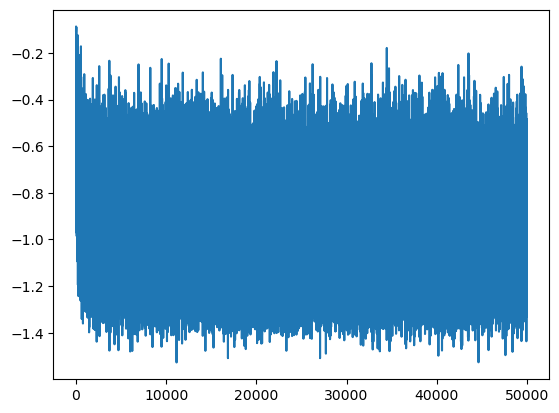

In [145]:
plt.plot(lossi)

# Evaluate loss

In [146]:
y_hat = net(test_X)
y_hat = y_hat * (std['SalePrice']**2 + eps)**0.5 + mean['SalePrice']
test_y = torch.tensor(np.array(test_label['SalePrice']), dtype=torch.float).view(-1, 1)

rmse = ((torch.log(test_y) - torch.log(y_hat))**2).mean().item()
print(rmse)

0.12920287251472473
